Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D


In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:

## Load the train dataset, and use validation_split 0.2 while definiting
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed=123,  # Setting the seed for reproducibility
    image_size=(img_height, img_width),  # Resizing images to the specified height and width
    batch_size=batch_size  # Using the defined batch size
)

# Verifying the structure of the dataset
for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", labels_batch.shape)

Found 2239 files belonging to 9 classes.
Image batch shape:  (32, 180, 180, 3)
Label batch shape:  (32,)


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:

# Define the test_ds from data_dir_test

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 118 files belonging to 9 classes.


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

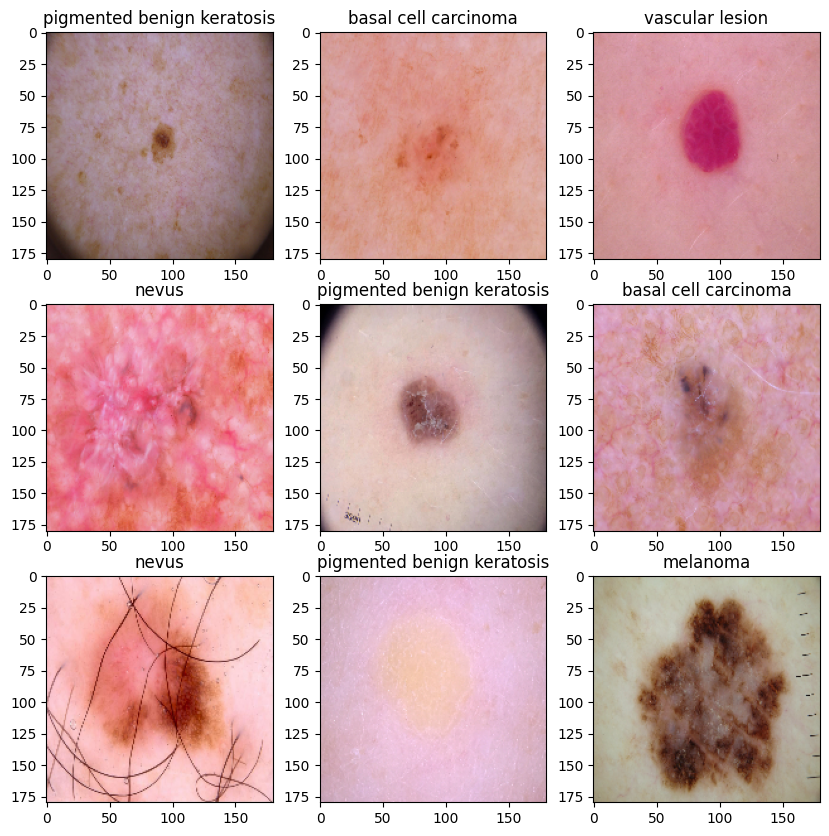

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
# Rescale the image
preprocessing_layers = [tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))]
input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,827,049 (121.41 MB)

 Trainable params: 31,827,049 (121.41 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.2522 - loss: 2.1900 - val_accuracy: 0.3602 - val_loss: 1.7122
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4162 - loss: 1.6563 - val_accuracy: 0.5078 - val_loss: 1.4468
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4541 - loss: 1.5707 - val_accuracy: 0.4497 - val_loss: 1.4808
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4934 - loss: 1.4657 - val_accuracy: 0.5548 - val_loss: 1.3259
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5234 - loss: 1.3455 - val_accuracy: 0.5391 - val_loss: 1.2431
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5505 - loss: 1.2955 - val_accuracy: 0.5817 - val_loss: 1.1849
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.5629 - loss: 1.2115 - val_accuracy: 0.5638 - val_loss: 1.0740
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5631 - loss: 1.2473 - val_accuracy: 0.6018 -

**overfit/under-fit (check the accuracy)?**

In [20]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8421 - loss: 0.4035
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8350 - loss: 0.3577
Accuracy:  0.8517194986343384
Validation Accuracy:  0.8411633372306824
Loss:  0.3841277062892914
Validation Loss 0.3616274893283844


### Visualizing training results

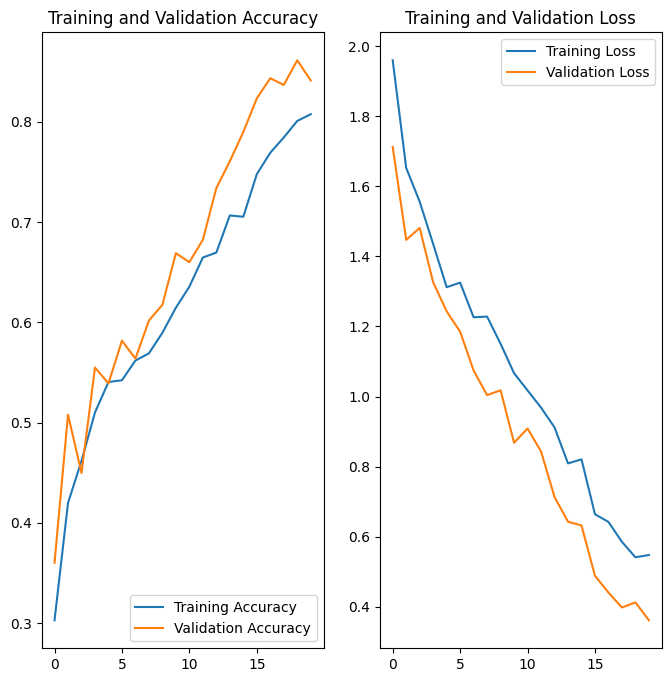

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Initial findings
In 20 epochs, we can observe the training accuracy is around 85.17%, where as validation accuracy is 84.11%. In terms of training and validation loss, we can observe training and validation loss continuous decreases.

**Model is underfitting.**

**Handle overfitting/undrefitting (Data augmentation)**
Data augmentation can be used in deep learning to handle overfitting/underfitting. It can be used to generate more sample images by flipping or random rotation

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
from keras.src.legacy.preprocessing.image import ImageDataGenerator

data_aug = keras.Sequential([
       layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
       layers.RandomRotation(0.2, fill_mode='reflect'),
       layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

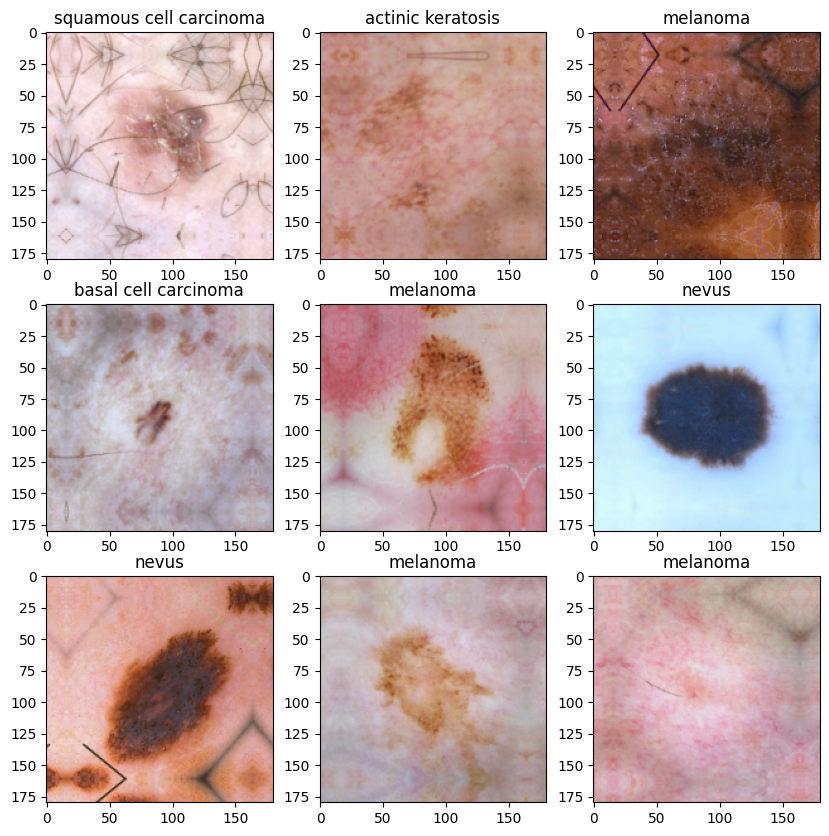

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in  train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
plt.show()


**Retraining the model by using Drop out layer to reduce overfitting/underfitting**

In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
input_shape = (180,180,3)
num_classes = 9

model = Sequential([ data_aug,
   layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


**Compiling the model**

In [27]:
## Your code goes here
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

In [28]:

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,827,049 (121.41 MB)

 Trainable params: 31,827,049 (121.41 MB)

 Non-trainable params: 0 (0.00 B)

**Training the model**

In [29]:

## Your code goes here
# Train model for more number of epochs to get better accuracy

epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.1707 - loss: 2.4586 - val_accuracy: 0.2058 - val_loss: 2.0306
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.1976 - loss: 2.0293 - val_accuracy: 0.2461 - val_loss: 1.9071
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.2803 - loss: 1.8811 - val_accuracy: 0.3311 - val_loss: 1.7998
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.3491 - loss: 1.7778 - val_accuracy: 0.3893 - val_loss: 1.7720
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.3702 - loss: 1.7429 - val_accuracy: 0.4541 - val_loss: 1.5978
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.4257 - loss: 1.6081 - val_accuracy: 0.4251 - val_loss: 1.6378
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4786 - loss: 1.5536 - val_accuracy: 0.3982 - val_loss: 1.6613
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.4561 - loss: 1.5417 - val_accuracy: 0.4922 - val_los

In [30]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5565 - loss: 1.1939
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5825 - loss: 1.1702
Accuracy:  0.5542653203010559
Validation Accuracy:  0.5480984449386597
Loss:  1.1945791244506836
Validation Loss 1.2159396409988403


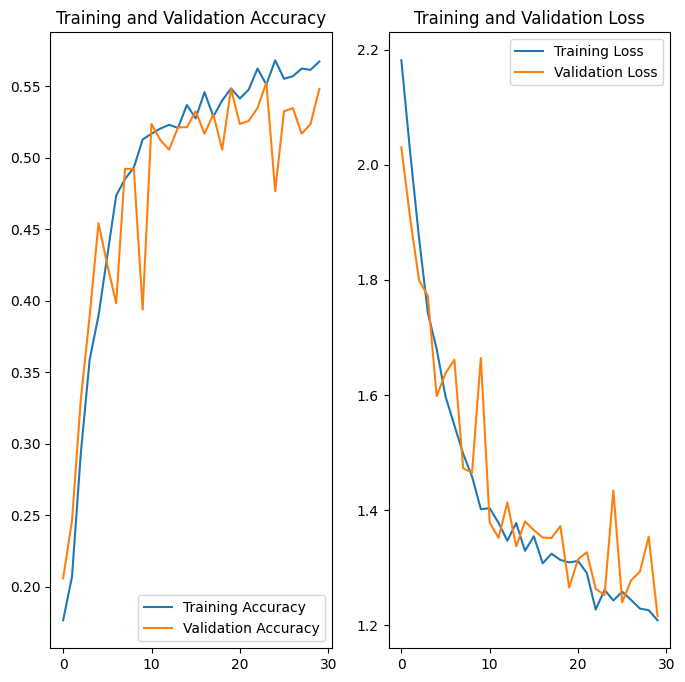

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**
With data augmentation strategy, we can see that training and validation accuracy fairly aligns and remain constant, where training and validation loss constantly decreases over period of time.

Though model accuracy has gone down, but model is not overfitting and requires more hyper parameter tuning. one of the option could be to train for more number of epocs and see the accuracy.

**Todo:** Find the distribution of classes in the training dataset.

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

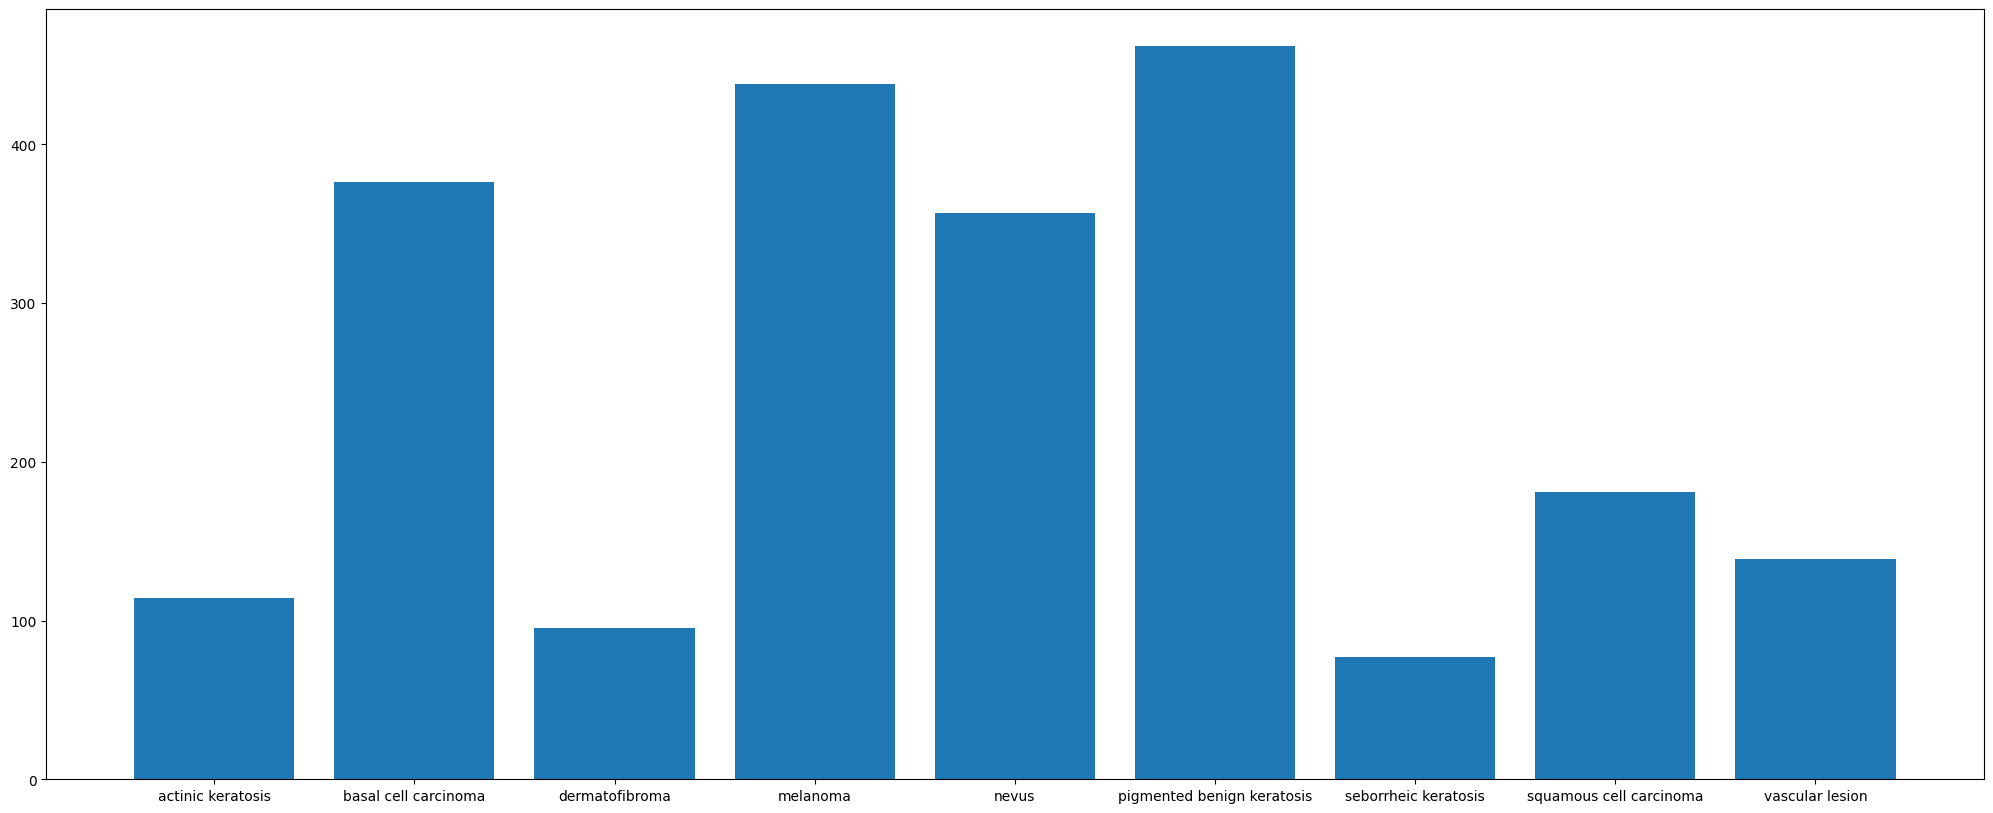

In [32]:

## Your code goes here.

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Todo**: Write your findings here:
- Which class has the least number of samples?

   Class has least number of samples is 'seborrheic keratosis'
- Which classes dominate the data in terms proportionate number of samples?

  Class "pigmented benign keratosis" dominate the data in presence

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:

path_to_training_dataset = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train")

# Loop through each class and apply augmentation
for class_name in class_names:
    # Create the full path for the class directory using pathlib
    class_path = path_to_training_dataset / class_name

    # Initialize the Augmentor pipeline for the class
    p = Augmentor.Pipeline(str(class_path))  # Convert path to string for Augmentor

    # Add rotation to the pipeline
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Generate 500 augmented samples for this class
    p.sample(500)  # Ensuring that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EE75A41B7F0>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE75A42FD30>: 100%|██████████| 500/500 [00:20<00:00, 24.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EE75A487B50>: 100%|██████████| 500/500 [00:19<00:00, 26.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE75A4BE6E0>: 100%|██████████| 500/500 [01:13<00:00,  6.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7EE75A447250>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE75A42E770>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE76817EAD0>: 100%|██████████| 500/500 [00:39<00:00, 12.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE76817EAA0>: 100%|██████████| 500/500 [00:18<00:00, 27.33 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EE75A447B50>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
image_count_train = len(list(path_to_training_dataset.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [47]:
import glob

In [48]:
# Define the path to the training dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')

# Use glob to find all .jpg files inside the "output" directories of each class
path_list = glob.glob(os.path.join(str(data_dir_train), '*', 'output', '*.jpg'))

# Check the result
print(path_list)

['/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_2c4f4769-3415-40d8-81d2-d51732bc6fd4.jpg', '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010834.jpg_e87cb6d0-1133-4bc8-abc3-e5b6702a81cd.jpg', '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_3f3c70d4-515d-4958-b141-d8ca358ccdfe.jpg', '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_a71ce6c2-ad15-413d-b989-ce2268894781.jpg', '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collabo

In [49]:
# Correct usage of glob.glob to list files
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(str(data_dir_train), '*', 'output', '*.jpg'))]

# Print the result
print(lesion_list_new)

['seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis', 'seborrheic ker

In [50]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2) ## in upgrad content we can not see original_df
new_df = df2

In [53]:
new_df['Label'].value_counts()

,count
Label,
seborrheic keratosis,500
vascular lesion,500
pigmented benign keratosis,500
actinic keratosis,500
dermatofibroma,500
nevus,500
squamous cell carcinoma,500
basal cell carcinoma,500
melanoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [54]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [55]:
data_dir_train = '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [60]:
## your code goes here

# Rescale the image
preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [62]:

## your code goes here
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

In [63]:

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,827,049 (121.41 MB)

 Trainable params: 31,827,049 (121.41 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [64]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 49s 274ms/step - accuracy: 0.1769 - loss: 2.2278 - val_accuracy: 0.2725 - val_loss: 1.9264
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.3601 - loss: 1.6826 - val_accuracy: 0.4232 - val_loss: 1.5388
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 238ms/step - accuracy: 0.4517 - loss: 1.4654 - val_accuracy: 0.4974 - val_loss: 1.3266
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 254ms/step - accuracy: 0.5107 - loss: 1.2966 - val_accuracy: 0.5531 - val_loss: 1.1966
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - accuracy: 0.5511 - loss: 1.1793 - val_accuracy: 0.6013 - val_loss: 1.0549
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - accuracy: 0.6069 - loss: 1.0713 - val_accuracy: 0.6563 - val_loss: 0.9648
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 239ms/step - accuracy: 0.6749 - loss: 0.8738 - val_accuracy: 0.7030 - val_loss: 0.8460
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.7250 - loss: 0.7746 - val

In [65]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.9603 - loss: 0.0955
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8394 - loss: 0.6690
Accuracy:  0.966431736946106
Validation Accuracy:  0.8277654051780701
Loss:  0.08232211321592331
Validation Loss 0.8098781704902649


#### **Todo:**  Visualize the model results

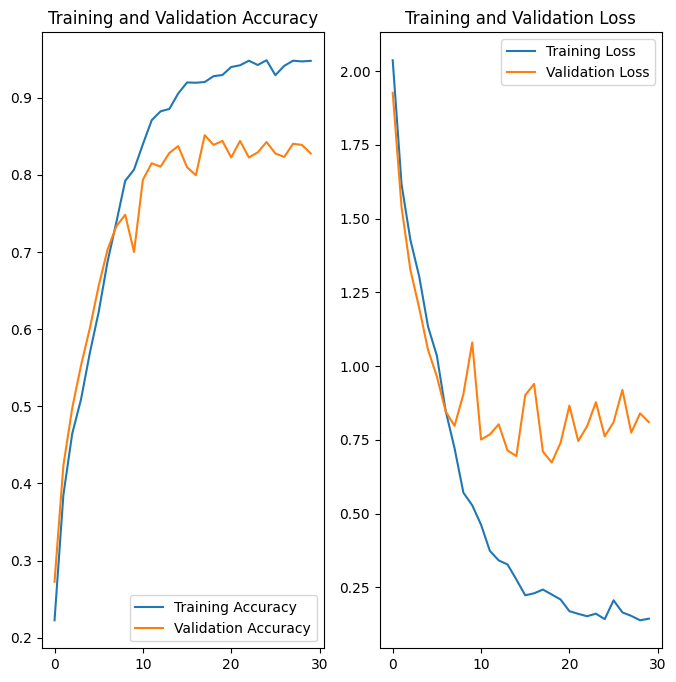

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**With class imbalance** and generating some sample images, we can see that training and validation accuracy has gone up. Training accuracy has increased upto > 96% and validation accuracy is around 82%.

With more hyper parameter tunining, accuracy can be increased further.

**Final summary**
At first, model was underfitting with basic sample images where training accuracy was approx 85% and validation accuracy was 84%

With basic tuning and help of ImageDataGenerator we were able to train the sample further and model seems to perform better where training and validation accuracy both were close to 55%.

With class imbalance and generating more sample images, we could notice model improved further and training and validation accuracy both > 82%.